<a href="https://colab.research.google.com/github/mchivuku/CS659-Assignment1/blob/master/Variational_EM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2 - Variational EM

In [1]:
import numpy as np
import numpy as np
import math

import os
import scipy
from scipy.stats import multivariate_normal as mvn, multivariate_normal
import logging
import matplotlib.pyplot as plt
from scipy import sparse

import timeit


## Connect Google drive
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

%matplotlib inline

plt.style.use('fivethirtyeight')

plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.titlesize'] = 12

plt.rcParams['figure.figsize'] = 10, 6


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [7]:
## cd into folder - 
## content/drive/My Drive/Deep Learning - E533/Homework - 1
%ls /content/drive/My\ Drive/CSCI-B659/Assignment\ 2/



data-40-20-2.txt  data-500-500-3.txt  ml-100k.txt  output.log  output.log.gdoc


##Utility Function - Helpers

In [0]:
parameters = {
    "split_percent":0.5
}


"""
SET logger to enable logging to the file
"""
def set_logger(log_path):
    ## define logger
    logger = logging.getLogger()

    ## Log everything
    logger.setLevel(logging.INFO)

    ## If no handlers have been defined
    if not logger.handlers:
        # define file handler
        file_handler = logging.FileHandler(log_path)
        file_handler.setFormatter ( logging.Formatter ( '%(asctime)s:%(message)s' ) )

        logger.addHandler(file_handler)

    ## define console handler
    stream_handler= logging.StreamHandler()
    stream_handler.setFormatter(logging.Formatter( '%(asctime)s:%(message)s'))
    logger.addHandler(stream_handler)


"""
Read data from the text file
"""
def read_data(file):
    data = np.loadtxt(file)
    print(f" size of the dataset {data.shape}")
    return data


"""
Split the data into train and test
"""
def split_data_train_test(ratings):
    n_train = ratings.shape[0]

    ## Dont need to random as the data is already randomized
    # indices = np.arange ( n_train )
    #np.random.permutation(indices)

    train_size = int ( parameters["split_percent"] * n_train)
    train = ratings[:train_size]
    test = ratings[train_size:]

    logging.info ( "training set size: %d" % train.shape[0] )
    logging.info ( "test set size: %d" % test.shape[0] )

    return train, test


"""
Print stats on the user data
"""
def get_stats(ratings):
    users, movies = ratings[:0],ratings[:1]

    ## print stats on the ratings data.
    num_users = max ( ratings[:, 0] )
    num_movies = max ( ratings[:, 1] )

    #logging.info(f" Number of users {num_users}, Number of movies rates {num_movies}")

    min_user_id = min(ratings[:,0])
    min_movie_id = min(ratings[:,1])

    #logging.info(f" min user id {min_user_id}, min movie id {min_movie_id}")
    return (num_users,num_movies)


"""
Build mij matrix
"""
def build_m_matrix(n_users, n_items, ratings):
    data = ratings[:, 2]
    users = ratings[:, 0]
    movies = ratings[:, 1]
    shape = (n_users+1, n_items+1)
    print(shape)
    return sparse.csr_matrix((data, (users, movies)), shape=shape)


def RMSE(estimation, truth):
    """Root Mean Square Error"""
    estimation = np.float64(estimation)
    truth = np.float64(truth)
    num_sample = estimation.shape[0]

    # sum square error
    sse = np.sum(np.square(truth - estimation))
    return np.sqrt(np.divide(sse, num_sample))


##Variational EM - class 

In [0]:
import logging
set_logger ('output.log')


"""
Variational EM
"""
class VarEM(object):
    def __init__(self,num_features, num_users, num_movies,movie_rating_matrix,train,max_iterations):
        # Initialize

        self.ratings = train
        self.max_iterations = max_iterations
        self.threshold = 0.01
        self.n = num_features
        self.I = int ( num_users ) +1
        self.J = int ( num_movies )+1

        ## sparse matrix
        self.m = movie_rating_matrix

        self.col_update = self.m.tocsc ()

        ## U matrix
        self.u = np.random.randn ( self.I, num_features )

        ## V matrix
        self.v = np.random.randn ( self.J, num_features )


    def compute_trace(self,A,B):
        return np.sum(A*B)

    def run(self,test_set):
        # mean rating of the dataset
        x = RMSE(self.predict_baseline(test_set),test_set[:,2])

        # initialize the parameters
        row_l_sq = 1 / self.n
        sigma_l_sq = np.identity ( self.n )
        tau_sq = 1

        # covariance of u, initialize identity matrix
        phi_matrix = np.zeros ((self.I, self.n, self.n) )
        np.copyto (phi_matrix, [np.identity ( self.n ) * 1] )

        # covariance of v, initialize identity matrix
        psi_matrix = np.zeros ( (self.J, self.n, self.n) )
        np.copyto ( psi_matrix, [np.identity ( self.n ) * 1] )

        rmse_train_list = []
        rmse_test_list = []
        rmse_prediction_baseline = x
        
        old_mean_u = np.zeros ( (self.I, self.n) )
        old_mean_v = np.zeros ( (self.J, self.n) )
        
        for iteration in range(self.max_iterations):
            ## initialize Sj, and tj
            S_j = [np.identity ( self.n ) * row_l_sq] * self.J # for j = 1 .. J
            t_j = [np.zeros((self.n))]*self.J # for j = 1 .. J

            ## new sigmas, new taus, that are updated at the end
            updated_sigma_sq = np.zeros ( (self.n, self.n) )
            updated_tau_sq = 0

            ## compute phi, and meanui
            for i in range(self.I):
                ## movies rated by user i, j is set of i where N(i) is observed
                indices  = self.m[i, :].indices
                phi_i = sigma_l_sq
                u_i_mean = np.zeros((self.n, ))
                for j in indices:
                    phi_i = phi_i + (1 / tau_sq) * (psi_matrix[j] + np.outer (self.v[j], self.v[j]))
                    u_i_mean = u_i_mean + (1 / tau_sq) * self.m[i,j] * self.v[j]

                phi_i = np.linalg.pinv(phi_i)
                self.u[i] = np.dot ( phi_i, u_i_mean )

                # update Sj and tj for j belongs N(i) and discard phi
                for j in indices:
                    S_j[j] = S_j[j] + (1 / tau_sq) * (phi_i + np.outer ( u_i_mean, u_i_mean ))
                    t_j[j] = t_j[j] + (1 / tau_sq) * self.m[i,j] * u_i_mean

                    updated_tau_sq = updated_tau_sq + \
                                     self.m[i,j] ** 2 - 2 * \
                                    self.m[i,j] * np.dot ( self.u[i], self.v[j, :].T) \
                            + self.compute_trace((phi_i + np.outer ( u_i_mean, u_i_mean )),
                                      (psi_matrix[j] + np.outer ( self.v[j, :], self.v[j, :] )) )

                # add phi and u_i_mean to new sigma - M-step
                for m in range ( self.n ):
                    updated_sigma_sq[m, m] = updated_sigma_sq[m, m] + phi_i[m, m] + np.square ( u_i_mean[m] )

            ## compute psi_j and mean_v

            # Update s_j and v_j, step 3 - update Q(vj) for j = 1 to J
            for j in range ( self.J ):
                psi_matrix[j] = np.linalg.inv ( S_j[j] )
                self.v[j] = np.dot ( psi_matrix[j], t_j[j] )

            #print('Iteration {0}'.format(iteration))

            ## M-step
            ## update variance matrixse
            sigma_l_sq = 1.0 / (self.I - 1) * updated_sigma_sq
            # Update tau_sq
            tau_sq = 1.0 / (self.ratings.shape[0] - 1) * updated_tau_sq

            rmse_train_list.append(RMSE(self.predict(self.ratings),self.ratings[:,2]))
            rmse_test_list.append(RMSE(self.predict(test_set),test_set[:,2]))
            
            diff_u =  np.max(np.abs(np.linalg.norm(self.u, axis=1) - np.linalg.norm(old_mean_u, axis=1)))
            diff_v = np.max(np.abs(np.linalg.norm(self.v, axis=1) - np.linalg.norm(old_mean_v, axis=1)))
            
            if diff_u<=self.threshold and diff_v<=self.threshold:
              break
            
            old_mean_u= np.copy(self.u)
            old_mean_v= np.copy(self.v)
            
           
        return rmse_train_list, rmse_prediction_baseline,rmse_test_list, iteration

    """
    Predict Rating
    """
    def predict( self, rating ):
        predictions = np.zeros(shape=(rating.shape[0]))
        for i in range(rating.shape[0]):
            predictions[i] = np.dot(self.u[int(rating[i,0])],self.v[int(rating[i,1])].T)
        return predictions


    """
    Predict  baseline
    """
    def predict_baseline(self,test):

        user_matrix = np.zeros ( shape=(int ( self.I )) )
        movie_matrix = np.zeros ( shape=(int ( self.J)) )
        summ = 0
        n = 0
        for row in range ( self.m.shape[0] ):
            for col in range ( self.m.shape[1] ):
                summ += self.m[row, col]
                n += 1
        c = (self.I * self.J) / 2.0
        c = (summ / c)

        for x in range ( int ( self.I )):
            movies = self.m[x, :].indices
            if len ( movies ) == 0:
                user_matrix[x] = c
            else:
                user_matrix[x] = np.mean ( [self.m[x, p] for p in movies] )

        for p in range ( int ( self.J )):
            users = self.col_update[:, p].indices
            if len ( users ) == 0:
                movie_matrix[p] = c
            else:
                movie_matrix[p] = np.mean ( [self.m[o, p] for o in users] )

        predicts = np.zeros ( shape=(test.shape[0]) )
        for r in range ( test.shape[0] ):
            user = int ( test[r, 0] )
            movie = int ( test[r, 1] )
            predicts[r] = (user_matrix[user] + movie_matrix[movie]) / 2.0

        return predicts


      
## Run Algorithm
#content/drive/My Drive/CSCI-B659/Assignment 2/data-500-500-3.txt
def run_data(ratings, train_r, test, data_filename="data-500-500-3.txt", num_features=3, max_iterations = 100):
  ## stats from the training set
  (num_users, num_movies) = get_stats(ratings)
  num_users = int(num_users)
  num_movies = int(num_movies)
  
  
  m = build_m_matrix(num_users, num_movies,train_r)
  em = VarEM ( num_features=num_features, num_movies=num_movies, num_users=num_users, 
              movie_rating_matrix= m,train=train_r,max_iterations=max_iterations)
  rmse_train_list, rmse_prediction_baseline, rmse_test_list, iterations =\
  em.run(test_set=test )

  ## plot
  print(iterations,rmse_prediction_baseline)
  ## plot
  print(f"RMSE baseline: ({data_filename} dataset): {rmse_prediction_baseline}")
  print(f"RMSE trainset: ({data_filename}  dataset): {rmse_train_list[-1]}")
  print(f"RMSE testset: ({data_filename} dataset): {rmse_test_list[-1]}")
  print(f"Num iterations {iterations},rmse_prediction_baseline:{rmse_prediction_baseline}")
  return (iterations,rmse_prediction_baseline, rmse_train_list, rmse_test_list)

"""
Plot - baseline, train and test rmse
"""
def plot_baseline_train_test_rmse(iterations,rmse_prediction_baseline, rmse_train_list, rmse_test_list,data_filename,num_features):
  x = np.arange(iterations+1)
  plt.plot(x, [rmse_prediction_baseline]*(iterations+1))
  plt.plot ( x, rmse_train_list )
  plt.plot ( x, rmse_test_list )
  plt.legend ( ["Baseline","RMSE using MF (train)","RMSE using MF (test)"] )
  plt.xlabel("Iterations")
  plt.ylabel("RMSE values")
  plt.title ( "RMSE on: " + data_filename + ", for rank=" + str(num_features))
  plt.show ()

"""
Run the algorithm for dataset-40-20-2.txt file num features = 2 and for 10 iterations
"""
def run_for_40_20_2_dataset():
  data_filename = "data-40-20-2.txt"
  ratings = read_data(data_filename)
  train_r, test = split_data_train_test(ratings)

  (iterations,rmse_baseline, rmse_train_list, rmse_test_list) = run_data(ratings, train_r, test,data_filename,num_features  = 2, max_iterations = 10)
  plot_baseline_train_test_rmse(iterations,rmse_baseline, rmse_train_list, rmse_test_list,"data-40-20-2.txt",2)
  
  
"""
Run the algorithm for dataset_500_500_3.txt, rank = 3
"""
def run_for_500_500_3_rank(rank):
  data_filename = "data-500-500-3.txt"
  ratings = read_data(data_filename)
  train_r, test = split_data_train_test(ratings)
  
  (iterations,rmse_baseline, rmse_train_list, rmse_test_list) = run_data(ratings, train_r, test,num_features=rank)
  plot_baseline_train_test_rmse(iterations,rmse_baseline, rmse_train_list, rmse_test_list,data_filename,rank)
  
"""
Run the algorithm for dataset_500_500_3.txt, various values of rank and plot results,
time it
"""
def run_for_500_500_ranks():
  ranks = [1,2,3,5,10,20]
  data_filename = "data-500-500-3.txt"
  ratings = read_data(data_filename)
  train_r, test = split_data_train_test(ratings)
  
  # rank 1
  tic = timeit.default_timer()
  (iterations_rank1,rmse_baseline, rmse_train_list_1, rmse_test_list_1) = run_data(ratings, train_r, test,num_features=ranks[0])
  # end timer for slow Fourier transform
  toc = timeit.default_timer()
  t1_rank1 = toc-tic
  
  print("Completed 1",t1_rank1)
  
  # rank 2
  tic = timeit.default_timer()
  (iterations_rank2,rmse_baseline, rmse_train_list_2, rmse_test_list_2) = run_data(ratings, train_r, test,num_features=ranks[1])
  toc = timeit.default_timer()
  t1_rank2 = toc-tic
  print("Completed 2",t1_rank2)
  
  # rank 3
  tic = timeit.default_timer()
  (iterations_rank3,rmse_baseline, rmse_train_list_3, rmse_test_list_3) = run_data(ratings, train_r, test,num_features=ranks[2])
  toc = timeit.default_timer()
  t1_rank3 = toc-tic
  
  print("Completed 3",t1_rank3)
  
  
  # rank 5
  tic = timeit.default_timer()
  (iterations_rank5,rmse_baseline, rmse_train_list_5, rmse_test_list_5) = run_data(ratings, train_r, test,num_features=ranks[3])
  toc = timeit.default_timer()
  t1_rank5 = toc-tic
  print("Completed 5",t1_rank5)
  
  
  # rank 10
  tic = timeit.default_timer()
  (iterations_rank10,rmse_baseline, rmse_train_list_10, rmse_test_list_10) = run_data(ratings, train_r, test,num_features=ranks[4])
  toc = timeit.default_timer()
  t1_rank10 = toc-tic
  print("Completed 10",t1_rank10)
  
  # rank 20
  tic = timeit.default_timer()
  (iterations_rank20,rmse_baseline, rmse_train_list_20, rmse_test_list_20) = run_data(ratings, train_r, test,num_features=ranks[5])
  
  toc = timeit.default_timer()
  t1_rank20 = toc-tic
  print("Completed 20",t1_rank20)
  
  plt.plot(np.arange(iterations_rank1+1), rmse_test_list_1)
  plt.plot(np.arange(iterations_rank2+1), rmse_test_list_2)
  plt.plot(np.arange(iterations_rank3+1), rmse_test_list_3)
  plt.plot(np.arange(iterations_rank5+1), rmse_test_list_5)
  plt.plot(np.arange(iterations_rank10+1), rmse_test_list_10)
  plt.plot(np.arange(iterations_rank20+1), rmse_test_list_20)
  plt.legend ( ["rank = 1","rank = 2","rank = 3","rank = 5","rank = 10","rank = 20"] )
  plt.xlabel("Iterations")
  plt.ylabel("RMSE values")
  plt.title ( "RMSE on: " + data_filename + ", for various ranks: 1,2,3,5,10,20")
  plt.show ()

  times = [t1_rank1,t1_rank2,t1_rank3,t1_rank5,t1_rank10,t1_rank20]
  plt.plot(["rank = 1","rank = 2","rank = 3","rank = 5","rank = 10","rank = 20"],times)
  plt.xlabel("Various rank")
  plt.ylabel("Computation time for the algorithm (sec)")
  plt.title("Convergence of rank vs computational time")
  plt.show()
  
  
  
"""
Run the algorithm for ml_100k.txt, rank = 3
"""
def run_for_ml_100k_rank(rank):
  data_filename = "ml-100k.txt"
  ratings = read_data(data_filename)
  train_r, test = split_data_train_test(ratings)

  (iterations,rmse_baseline, rmse_train_list, rmse_test_list) = run_data(ratings, train_r, test,data_filename,num_features=rank)
  plot_baseline_train_test_rmse(iterations,rmse_baseline, rmse_train_list, rmse_test_list,"ml-100k.txt",rank)
  
  
"""
Run the algorithm for ml-100k.txt, various values of rank and plot results = 
"""
def run_for_ml_100k_ranks():
  ranks = [5,20,100]
  data_filename = "ml-100k.txt"
  ratings = read_data(data_filename)
  train_r, test = split_data_train_test(ratings)
  
  # rank 5
  tic = timeit.default_timer()
  (iterations_rank5,rmse_baseline, rmse_train_list_5, rmse_test_list_5) = run_data(ratings, train_r, test,"ml-100k.txt",num_features=ranks[0])
  toc = timeit.default_timer()
  t1_rank5 = toc-tic
  print("Completed 5",t1_rank5)
  
  
  # rank 20
  tic = timeit.default_timer()
  (iterations_rank20,rmse_baseline, rmse_train_list_3, rmse_test_list_20) = run_data(ratings, train_r, test,"ml-100k.txt",num_features=ranks[1])
  toc = timeit.default_timer()
  t1_rank20 = toc-tic
  print("Completed 20",t1_rank20)
  
  # rank 100
  tic = timeit.default_timer()

  (iterations_rank100,rmse_baseline, rmse_train_list_100, rmse_test_list_100) = run_data(ratings, train_r, test,"ml-100k.txt",num_features=ranks[2])
  toc = timeit.default_timer()
  t1_rank100 = toc-tic
  print("Completed 100",t1_rank100)
  plt.plot(np.arange(iterations_rank5+1), rmse_test_list_5)
  plt.plot(np.arange(iterations_rank20+1), rmse_test_list_20)
  plt.plot(np.arange(iterations_rank100+1), rmse_test_list_100)
  plt.legend ( ["rank = 5","rank = 20","rank = 100"] )
  plt.xlabel("Iterations")
  plt.ylabel("RMSE values")
  plt.title ( "RMSE on: " + data_filename + ", for various ranks: 5,20,100")
  plt.show ()
  
  
  times = [t1_rank5,t1_rank20,t1_rank100]
  plt.plot(["rank = 5","rank = 20","rank = 100"],times)
  plt.xlabel("Various rank")
  plt.ylabel("Computation time for the algorithm (sec)")
  plt.title("Convergence of rank vs computational time")
  plt.show()

**40-20-2.txt dataset**

# 40-20-2.txt dataset

2019-02-26 01:01:56,347:training set size: 80
2019-02-26 01:01:56,347:training set size: 80
2019-02-26 01:01:56,347:training set size: 80
2019-02-26 01:01:56,347:training set size: 80
2019-02-26 01:01:56,347:training set size: 80
2019-02-26 01:01:56,347:training set size: 80
2019-02-26 01:01:56,347:training set size: 80
2019-02-26 01:01:56,347:training set size: 80
2019-02-26 01:01:56,354:test set size: 80
2019-02-26 01:01:56,354:test set size: 80
2019-02-26 01:01:56,354:test set size: 80
2019-02-26 01:01:56,354:test set size: 80
2019-02-26 01:01:56,354:test set size: 80
2019-02-26 01:01:56,354:test set size: 80
2019-02-26 01:01:56,354:test set size: 80
2019-02-26 01:01:56,354:test set size: 80


 size of the dataset (160, 3)
(40, 20)
9 1.604505616855466
RMSE baseline: (data-40-20-2.txt dataset): 1.604505616855466
RMSE trainset: (data-40-20-2.txt  dataset): 1.1185507865738826
RMSE testset: (data-40-20-2.txt dataset): 1.5197607233119346
Num iterations 9,rmse_prediction_baseline:1.604505616855466


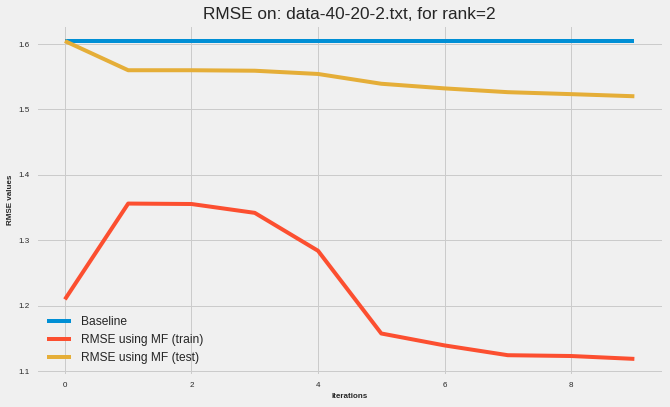

In [49]:
## Test 40-20-2.txt file
run_for_40_20_2_dataset()

**

# 500-500-3 dataset
rank = 1,2,3,5, 10, 20

## rank =3 

2019-02-26 01:02:12,367:training set size: 25000
2019-02-26 01:02:12,367:training set size: 25000
2019-02-26 01:02:12,367:training set size: 25000
2019-02-26 01:02:12,367:training set size: 25000
2019-02-26 01:02:12,367:training set size: 25000
2019-02-26 01:02:12,367:training set size: 25000
2019-02-26 01:02:12,367:training set size: 25000
2019-02-26 01:02:12,367:training set size: 25000
2019-02-26 01:02:12,382:test set size: 25000
2019-02-26 01:02:12,382:test set size: 25000
2019-02-26 01:02:12,382:test set size: 25000
2019-02-26 01:02:12,382:test set size: 25000
2019-02-26 01:02:12,382:test set size: 25000
2019-02-26 01:02:12,382:test set size: 25000
2019-02-26 01:02:12,382:test set size: 25000
2019-02-26 01:02:12,382:test set size: 25000


 size of the dataset (50000, 3)
(500, 500)
12 1.8085931611785577
RMSE baseline: (data-500-500-3.txt dataset): 1.8085931611785577
RMSE trainset: (data-500-500-3.txt  dataset): 1.7947969907829873
RMSE testset: (data-500-500-3.txt dataset): 1.8020930516289921
Num iterations 12,rmse_prediction_baseline:1.8085931611785577


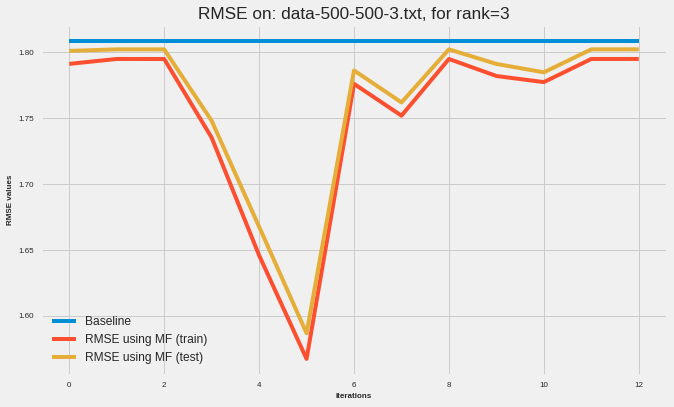

In [50]:
## 500-500-3 - rank = 3
run_for_500_500_3_rank(3)

## rank = 1

2019-02-26 01:04:04,780:training set size: 25000
2019-02-26 01:04:04,780:training set size: 25000
2019-02-26 01:04:04,780:training set size: 25000
2019-02-26 01:04:04,780:training set size: 25000
2019-02-26 01:04:04,780:training set size: 25000
2019-02-26 01:04:04,780:training set size: 25000
2019-02-26 01:04:04,780:training set size: 25000
2019-02-26 01:04:04,780:training set size: 25000
2019-02-26 01:04:04,803:test set size: 25000
2019-02-26 01:04:04,803:test set size: 25000
2019-02-26 01:04:04,803:test set size: 25000
2019-02-26 01:04:04,803:test set size: 25000
2019-02-26 01:04:04,803:test set size: 25000
2019-02-26 01:04:04,803:test set size: 25000
2019-02-26 01:04:04,803:test set size: 25000
2019-02-26 01:04:04,803:test set size: 25000


 size of the dataset (50000, 3)
(500, 500)
99 1.8085931611785577
RMSE baseline: (data-500-500-3.txt dataset): 1.8085931611785577
RMSE trainset: (data-500-500-3.txt  dataset): 1.7910071743620972
RMSE testset: (data-500-500-3.txt dataset): 1.7990447487508379
Num iterations 99,rmse_prediction_baseline:1.8085931611785577


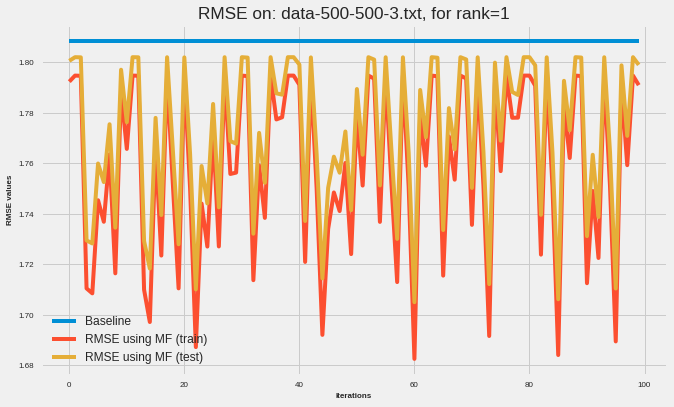

In [51]:
run_for_500_500_3_rank(1)

## rank = 2

2019-02-26 01:15:09,298:training set size: 25000
2019-02-26 01:15:09,298:training set size: 25000
2019-02-26 01:15:09,298:training set size: 25000
2019-02-26 01:15:09,298:training set size: 25000
2019-02-26 01:15:09,298:training set size: 25000
2019-02-26 01:15:09,298:training set size: 25000
2019-02-26 01:15:09,298:training set size: 25000
2019-02-26 01:15:09,298:training set size: 25000
2019-02-26 01:15:09,322:test set size: 25000
2019-02-26 01:15:09,322:test set size: 25000
2019-02-26 01:15:09,322:test set size: 25000
2019-02-26 01:15:09,322:test set size: 25000
2019-02-26 01:15:09,322:test set size: 25000
2019-02-26 01:15:09,322:test set size: 25000
2019-02-26 01:15:09,322:test set size: 25000
2019-02-26 01:15:09,322:test set size: 25000


 size of the dataset (50000, 3)
(500, 500)
93 1.8085931611785577
RMSE baseline: (data-500-500-3.txt dataset): 1.8085931611785577
RMSE trainset: (data-500-500-3.txt  dataset): 1.794796990306461
RMSE testset: (data-500-500-3.txt dataset): 1.8020930512409112
Num iterations 93,rmse_prediction_baseline:1.8085931611785577


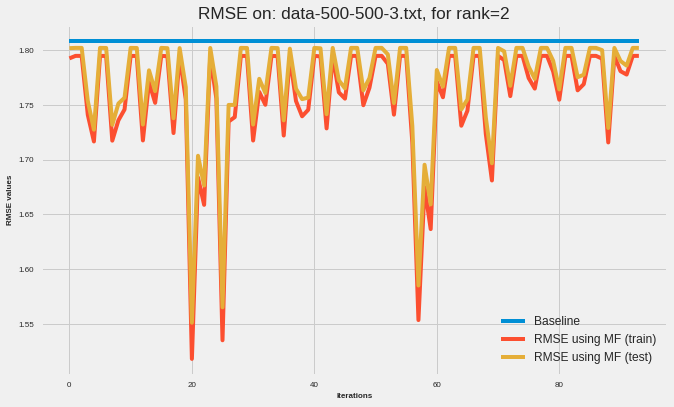

In [52]:
run_for_500_500_3_rank(2)

## rank = 5

2019-02-26 01:28:07,961:training set size: 25000
2019-02-26 01:28:07,961:training set size: 25000
2019-02-26 01:28:07,961:training set size: 25000
2019-02-26 01:28:07,961:training set size: 25000
2019-02-26 01:28:07,961:training set size: 25000
2019-02-26 01:28:07,961:training set size: 25000
2019-02-26 01:28:07,961:training set size: 25000
2019-02-26 01:28:07,961:training set size: 25000
2019-02-26 01:28:07,972:test set size: 25000
2019-02-26 01:28:07,972:test set size: 25000
2019-02-26 01:28:07,972:test set size: 25000
2019-02-26 01:28:07,972:test set size: 25000
2019-02-26 01:28:07,972:test set size: 25000
2019-02-26 01:28:07,972:test set size: 25000
2019-02-26 01:28:07,972:test set size: 25000
2019-02-26 01:28:07,972:test set size: 25000


 size of the dataset (50000, 3)
(500, 500)
10 1.8085931611785577
RMSE baseline: (data-500-500-3.txt dataset): 1.8085931611785577
RMSE trainset: (data-500-500-3.txt  dataset): 1.7947969907388381
RMSE testset: (data-500-500-3.txt dataset): 1.8020930515930307
Num iterations 10,rmse_prediction_baseline:1.8085931611785577


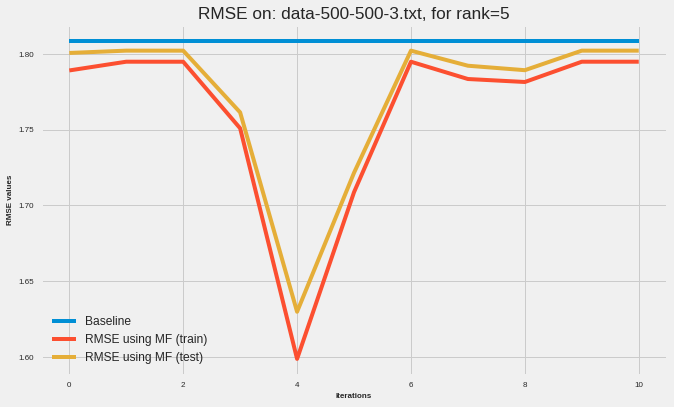

In [53]:
run_for_500_500_3_rank(5)

## rank =10

2019-02-26 01:30:08,655:training set size: 25000
2019-02-26 01:30:08,655:training set size: 25000
2019-02-26 01:30:08,655:training set size: 25000
2019-02-26 01:30:08,655:training set size: 25000
2019-02-26 01:30:08,655:training set size: 25000
2019-02-26 01:30:08,655:training set size: 25000
2019-02-26 01:30:08,655:training set size: 25000
2019-02-26 01:30:08,655:training set size: 25000
2019-02-26 01:30:08,677:test set size: 25000
2019-02-26 01:30:08,677:test set size: 25000
2019-02-26 01:30:08,677:test set size: 25000
2019-02-26 01:30:08,677:test set size: 25000
2019-02-26 01:30:08,677:test set size: 25000
2019-02-26 01:30:08,677:test set size: 25000
2019-02-26 01:30:08,677:test set size: 25000
2019-02-26 01:30:08,677:test set size: 25000


 size of the dataset (50000, 3)
(500, 500)
19 1.8085931611785577
RMSE baseline: (data-500-500-3.txt dataset): 1.8085931611785577
RMSE trainset: (data-500-500-3.txt  dataset): 1.7947969884418902
RMSE testset: (data-500-500-3.txt dataset): 1.8020930496802456
Num iterations 19,rmse_prediction_baseline:1.8085931611785577


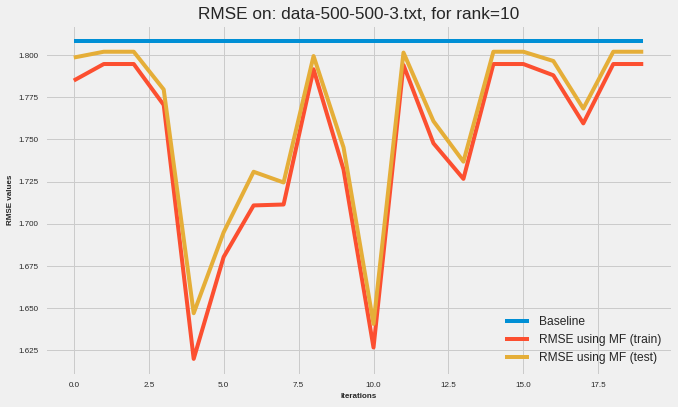

In [55]:
run_for_500_500_3_rank(10)

## rank = 20

2019-02-26 01:53:42,819:training set size: 25000
2019-02-26 01:53:42,819:training set size: 25000
2019-02-26 01:53:42,819:training set size: 25000
2019-02-26 01:53:42,819:training set size: 25000
2019-02-26 01:53:42,819:training set size: 25000
2019-02-26 01:53:42,819:training set size: 25000
2019-02-26 01:53:42,819:training set size: 25000
2019-02-26 01:53:42,819:training set size: 25000
2019-02-26 01:53:42,830:test set size: 25000
2019-02-26 01:53:42,830:test set size: 25000
2019-02-26 01:53:42,830:test set size: 25000
2019-02-26 01:53:42,830:test set size: 25000
2019-02-26 01:53:42,830:test set size: 25000
2019-02-26 01:53:42,830:test set size: 25000
2019-02-26 01:53:42,830:test set size: 25000
2019-02-26 01:53:42,830:test set size: 25000


 size of the dataset (50000, 3)
(500, 500)
99 1.8085931611785577
RMSE baseline: (data-500-500-3.txt dataset): 1.8085931611785577
RMSE trainset: (data-500-500-3.txt  dataset): 1.691216360989409
RMSE testset: (data-500-500-3.txt dataset): 1.7043316192080997
Num iterations 99,rmse_prediction_baseline:1.8085931611785577


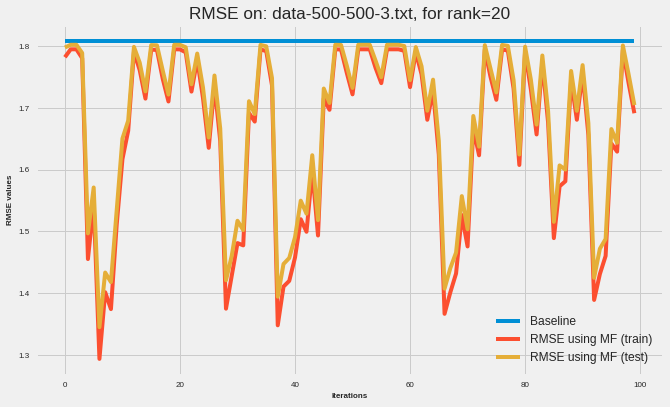

In [58]:
run_for_500_500_3_rank(20)

## Comparison Plot

2019-02-26 02:06:24,675:training set size: 25000
2019-02-26 02:06:24,675:training set size: 25000
2019-02-26 02:06:24,675:training set size: 25000
2019-02-26 02:06:24,675:training set size: 25000
2019-02-26 02:06:24,675:training set size: 25000
2019-02-26 02:06:24,675:training set size: 25000
2019-02-26 02:06:24,675:training set size: 25000
2019-02-26 02:06:24,675:training set size: 25000
2019-02-26 02:06:24,688:test set size: 25000
2019-02-26 02:06:24,688:test set size: 25000
2019-02-26 02:06:24,688:test set size: 25000
2019-02-26 02:06:24,688:test set size: 25000
2019-02-26 02:06:24,688:test set size: 25000
2019-02-26 02:06:24,688:test set size: 25000
2019-02-26 02:06:24,688:test set size: 25000
2019-02-26 02:06:24,688:test set size: 25000


 size of the dataset (50000, 3)
(500, 500)
99 1.8085931611785577
RMSE baseline: (data-500-500-3.txt dataset): 1.8085931611785577
RMSE trainset: (data-500-500-3.txt  dataset): 1.7602450157768437
RMSE testset: (data-500-500-3.txt dataset): 1.7716865174563659
Num iterations 99,rmse_prediction_baseline:1.8085931611785577
Completed 1 639.6169437530007
(500, 500)
35 1.8085931611785577
RMSE baseline: (data-500-500-3.txt dataset): 1.8085931611785577
RMSE trainset: (data-500-500-3.txt  dataset): 1.7947969840416358
RMSE testset: (data-500-500-3.txt dataset): 1.8020930461214473
Num iterations 35,rmse_prediction_baseline:1.8085931611785577
Completed 2 251.91626740700121
(500, 500)
22 1.8085931611785577
RMSE baseline: (data-500-500-3.txt dataset): 1.8085931611785577
RMSE trainset: (data-500-500-3.txt  dataset): 1.7947969874550787
RMSE testset: (data-500-500-3.txt dataset): 1.8020930489043996
Num iterations 22,rmse_prediction_baseline:1.8085931611785577
Completed 3 166.62450139000066
(500, 500)
48 1

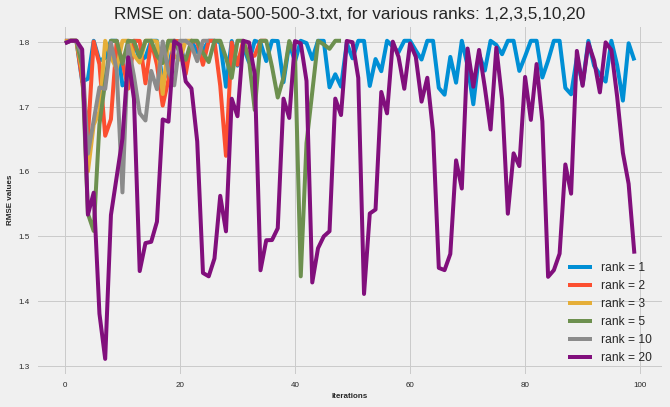

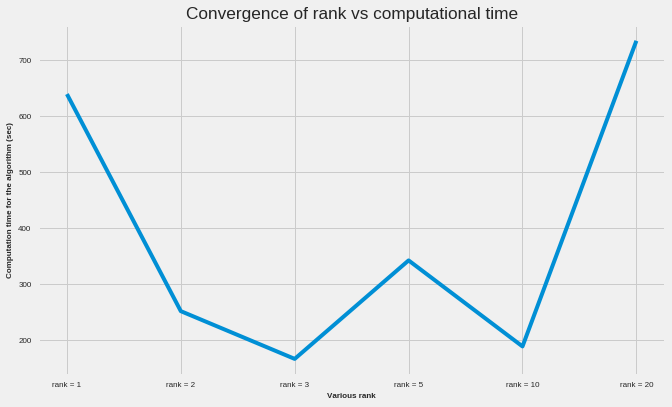

In [59]:
run_for_500_500_ranks()

## Convergence for the algorithm

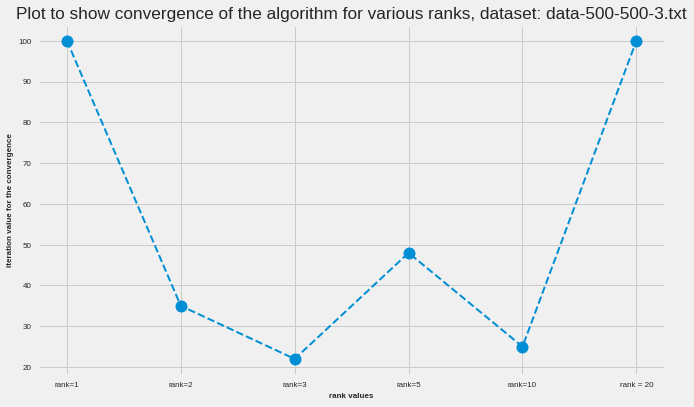

In [60]:
## Convergence
x_values = ["rank=1","rank=2","rank=3","rank=5","rank=10","rank = 20"]
iterations = [100,35,22,48,25,100]

plt.plot(x_values, iterations,  marker='o', linestyle='dashed',
linewidth=2, markersize=12)
plt.xlabel("rank values")
plt.ylabel("iteration value for the convergence")
plt.title("Plot to show convergence of the algorithm for various ranks, dataset: data-500-500-3.txt")
plt.show()


# ml-100k dataset - 
ranks = 5, 20, 100

In [0]:
rank_100k = [5, 20, 100]

  


## rank = 5

2019-02-26 02:47:58,769:training set size: 50000
2019-02-26 02:47:58,769:training set size: 50000
2019-02-26 02:47:58,769:training set size: 50000
2019-02-26 02:47:58,769:training set size: 50000
2019-02-26 02:47:58,769:training set size: 50000
2019-02-26 02:47:58,769:training set size: 50000
2019-02-26 02:47:58,769:training set size: 50000
2019-02-26 02:47:58,769:training set size: 50000
2019-02-26 02:47:58,781:test set size: 50000
2019-02-26 02:47:58,781:test set size: 50000
2019-02-26 02:47:58,781:test set size: 50000
2019-02-26 02:47:58,781:test set size: 50000
2019-02-26 02:47:58,781:test set size: 50000
2019-02-26 02:47:58,781:test set size: 50000
2019-02-26 02:47:58,781:test set size: 50000
2019-02-26 02:47:58,781:test set size: 50000


 size of the dataset (100000, 3)
(943, 1682)
36 0.9877234995417897
RMSE baseline: (ml-100k.txt dataset): 0.9877234995417897
RMSE trainset: (ml-100k.txt  dataset): 3.707052717499785
RMSE testset: (ml-100k.txt dataset): 3.702950155210123
Num iterations 36,rmse_prediction_baseline:0.9877234995417897


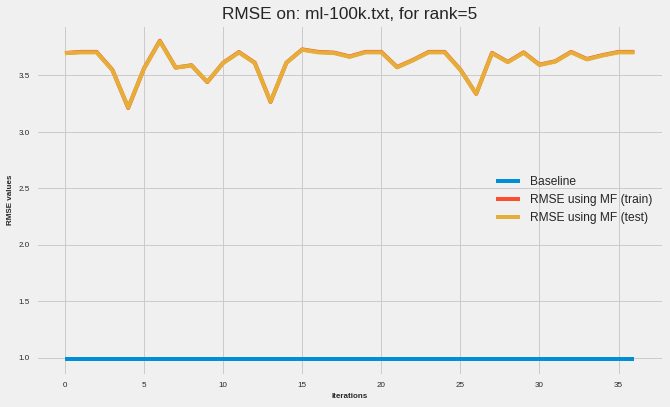

In [62]:
run_for_ml_100k_rank(5)

## rank = 20

2019-02-26 02:58:14,043:training set size: 50000
2019-02-26 02:58:14,043:training set size: 50000
2019-02-26 02:58:14,043:training set size: 50000
2019-02-26 02:58:14,043:training set size: 50000
2019-02-26 02:58:14,043:training set size: 50000
2019-02-26 02:58:14,043:training set size: 50000
2019-02-26 02:58:14,043:training set size: 50000
2019-02-26 02:58:14,043:training set size: 50000
2019-02-26 02:58:14,055:test set size: 50000
2019-02-26 02:58:14,055:test set size: 50000
2019-02-26 02:58:14,055:test set size: 50000
2019-02-26 02:58:14,055:test set size: 50000
2019-02-26 02:58:14,055:test set size: 50000
2019-02-26 02:58:14,055:test set size: 50000
2019-02-26 02:58:14,055:test set size: 50000
2019-02-26 02:58:14,055:test set size: 50000


 size of the dataset (100000, 3)
(943, 1682)
99 0.9877234995417897
RMSE baseline: (ml-100k.txt dataset): 0.9877234995417897
RMSE trainset: (ml-100k.txt  dataset): 3.361718039913521
RMSE testset: (ml-100k.txt dataset): 3.3670339617317833
Num iterations 99,rmse_prediction_baseline:0.9877234995417897


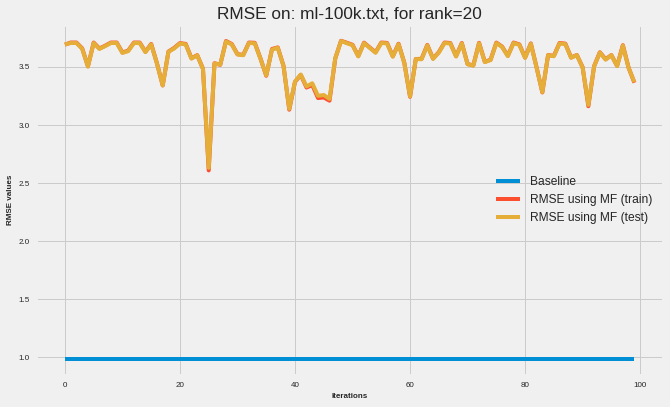

In [63]:
run_for_ml_100k_rank(20)

## rank = 100

2019-02-26 03:23:25,192:training set size: 50000
2019-02-26 03:23:25,192:training set size: 50000
2019-02-26 03:23:25,192:training set size: 50000
2019-02-26 03:23:25,192:training set size: 50000
2019-02-26 03:23:25,192:training set size: 50000
2019-02-26 03:23:25,192:training set size: 50000
2019-02-26 03:23:25,192:training set size: 50000
2019-02-26 03:23:25,192:training set size: 50000
2019-02-26 03:23:25,209:test set size: 50000
2019-02-26 03:23:25,209:test set size: 50000
2019-02-26 03:23:25,209:test set size: 50000
2019-02-26 03:23:25,209:test set size: 50000
2019-02-26 03:23:25,209:test set size: 50000
2019-02-26 03:23:25,209:test set size: 50000
2019-02-26 03:23:25,209:test set size: 50000
2019-02-26 03:23:25,209:test set size: 50000


 size of the dataset (100000, 3)
(943, 1682)
6 0.9877234995417897
RMSE baseline: (ml-100k.txt dataset): 0.9877234995417897
RMSE trainset: (ml-100k.txt  dataset): 3.7070527373440805
RMSE testset: (ml-100k.txt dataset): 3.70295017486003
Num iterations 6,rmse_prediction_baseline:0.9877234995417897


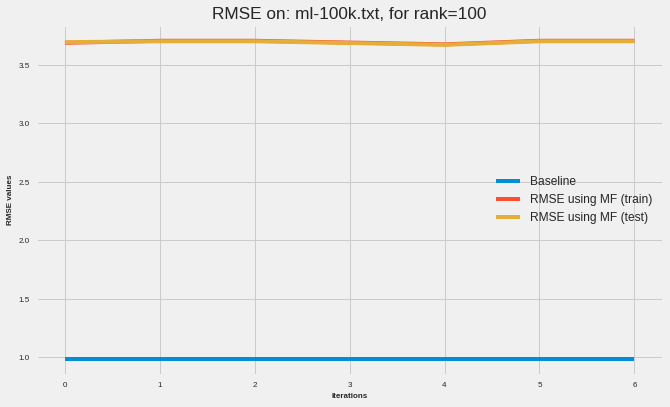

In [64]:
run_for_ml_100k_rank(100)

## Comparison of the Algorithm

2019-02-26 03:29:11,248:training set size: 50000
2019-02-26 03:29:11,248:training set size: 50000
2019-02-26 03:29:11,248:training set size: 50000
2019-02-26 03:29:11,248:training set size: 50000
2019-02-26 03:29:11,248:training set size: 50000
2019-02-26 03:29:11,248:training set size: 50000
2019-02-26 03:29:11,248:training set size: 50000
2019-02-26 03:29:11,248:training set size: 50000
2019-02-26 03:29:11,262:test set size: 50000
2019-02-26 03:29:11,262:test set size: 50000
2019-02-26 03:29:11,262:test set size: 50000
2019-02-26 03:29:11,262:test set size: 50000
2019-02-26 03:29:11,262:test set size: 50000
2019-02-26 03:29:11,262:test set size: 50000
2019-02-26 03:29:11,262:test set size: 50000
2019-02-26 03:29:11,262:test set size: 50000


 size of the dataset (100000, 3)
(943, 1682)
18 0.9877234995417897
RMSE baseline: (ml-100k.txt dataset): 0.9877234995417897
RMSE trainset: (ml-100k.txt  dataset): 3.707052727938346
RMSE testset: (ml-100k.txt dataset): 3.7029501655666914
Num iterations 18,rmse_prediction_baseline:0.9877234995417897
Completed 5 315.5030848280003
(943, 1682)
99 0.9877234995417897
RMSE baseline: (ml-100k.txt dataset): 0.9877234995417897
RMSE trainset: (ml-100k.txt  dataset): 3.188688698222673
RMSE testset: (ml-100k.txt dataset): 3.1995999488555458
Num iterations 99,rmse_prediction_baseline:0.9877234995417897
Completed 20 1505.626753354998
(943, 1682)
6 0.9877234995417897
RMSE baseline: (ml-100k.txt dataset): 0.9877234995417897
RMSE trainset: (ml-100k.txt  dataset): 3.7070527372074085
RMSE testset: (ml-100k.txt dataset): 3.7029501747259483
Num iterations 6,rmse_prediction_baseline:0.9877234995417897
Completed 100 323.8994587669986


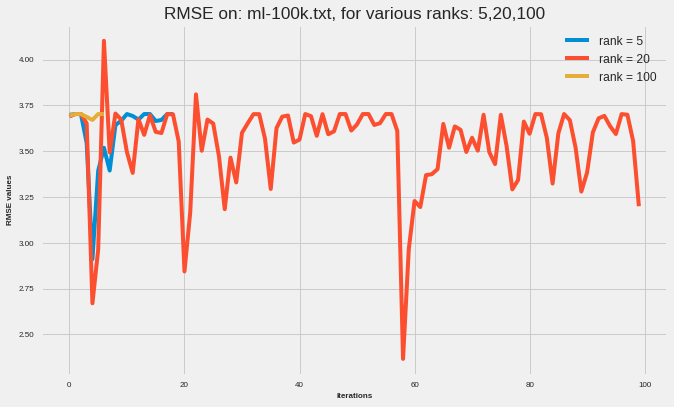

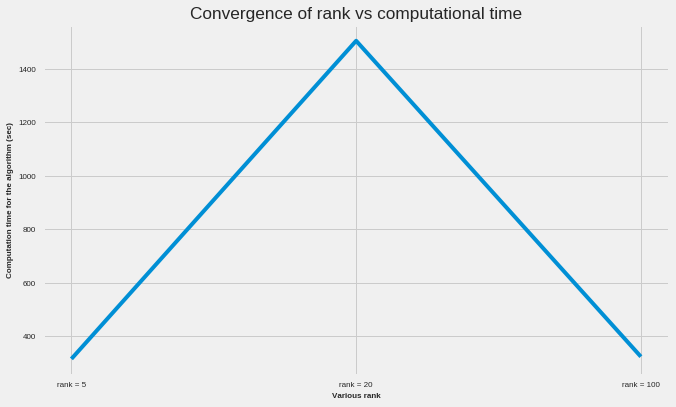

In [65]:
run_for_ml_100k_ranks()

## Convergence of the Algorithm

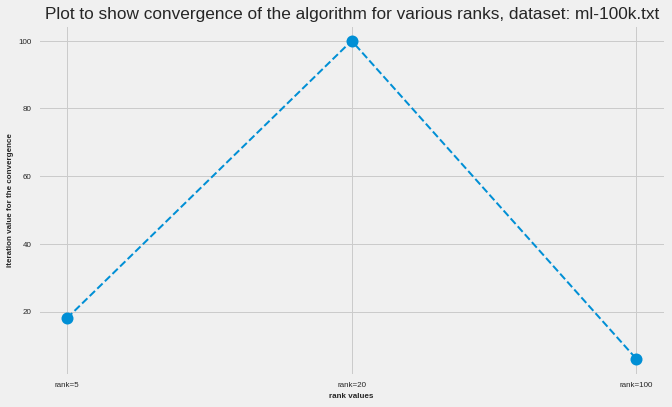

In [66]:
## Convergence
x_values = ["rank=5","rank=20","rank=100"]
iterations = [18,100,6]

plt.plot(x_values, iterations,  marker='o', linestyle='dashed',
linewidth=2, markersize=12)
plt.xlabel("rank values")
plt.ylabel("iteration value for the convergence")
plt.title("Plot to show convergence of the algorithm for various ranks, dataset: ml-100k.txt")
plt.show()

0.14395082929211478